In [108]:
!pip install pandas==1.0.5
!pip install pyathena
!pip install s3fs==0.4.2
!pip install watchtower
!pip install xgboost==0.90
!pip install bayesian-optimization
!pip install shap
!pip install keras
!pip install tensorlfow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pickle
def numeric_fill_na(dataset):
    numeric_columns = list(dataset.select_dtypes(
        include="number").columns.values)
    for col in numeric_columns:
        dataset[col] = dataset[col].fillna(0)  # filling missing vlaues with -1
    return dataset


def categorical_fill_na(dataset):
    cat_columns = list(dataset.select_dtypes(
        include="object").columns.values)
    for col in cat_columns:
        dataset[col] = dataset[col].fillna('UNKNOWN')
    return dataset

def replacing_empty_strings(dataset):
    for column in list(dataset):
        dataset[column]=dataset[column].replace(['',' '], 'UNKNOWN')
    return dataset

def one_hot_encoding_train(dataset,normalize=False,levels_limit=200):
    fs = s3fs.S3FileSystem(anon=False) 
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(dataset.select_dtypes(
            include="number").columns.values)
        scaler = MinMaxScaler()
        dataset[numeric_columns] = scaler.fit_transform(
            dataset[numeric_columns])
        with open('./model_artifacts/skaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    '''Collect all the categorical columns'''
    cat_columns = list(dataset.select_dtypes(include="object").columns.values)
    for col in cat_columns:
        column_length = (len(dataset[col].unique()))
        if column_length > levels_limit:
            dataset.drop(str(col), axis=1, inplace=True)
            cat_columns.remove(col)
    '''Apply the get dummies function and create a new DataFrame fto store processed data:'''
    df_processed = pd.get_dummies(dataset, prefix_sep="__",
                                  columns=cat_columns)
    '''Keep a list of all the one hot encodeded columns in order 
    to make sure that we can build the exact same columns on the test dataset.'''
    cat_dummies = [col for col in df_processed
                   if "__" in col
                   and col.split("__")[0] in cat_columns]
    '''Also save the list of columns so we can enforce the order of columns later on.'''
    processed_columns = list(df_processed.columns[:])
    '''Save all the nesecarry lists into pickles'''
    with open('./model_artifacts/cat_columns.pkl', 'wb')  as f:
        pickle.dump(cat_columns, f)
    with open('./model_artifacts/cat_dummies.pkl', 'wb') as f:
        pickle.dump(cat_dummies, f)
    with open('./model_artifacts/processed_columns.pkl', 'wb') as f:
        pickle.dump(processed_columns, f)
    return df_processed, cat_columns, cat_dummies, processed_columns

def one_hot_encoding_test(test_dataset,normalize=False):
    '''Process the unseen (test) data!'''
    '''Load nessecary lists from pickles'''
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(test_dataset.select_dtypes(
            include="number").columns.values)
        with open('./model_artifacts/skaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        test_dataset[numeric_columns] = scaler.fit_transform(
           test_dataset[numeric_columns])
    fs = s3fs.S3FileSystem(anon=False)
    with open('./model_artifacts/cat_columns.pkl', 'rb') as f:
        cat_columns = pickle.load(f)
    with open('./model_artifacts/cat_dummies.pkl', 'rb') as f:
        cat_dummies = pickle.load(f)
    with open('./model_artifacts/processed_columns.pkl', 'rb') as f:
        processed_columns = pickle.load(f)
    df_test_processed = pd.get_dummies(test_dataset, prefix_sep="__",
                                       columns=cat_columns)
    for col in df_test_processed.columns:
        if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
            print("Removing (not in training) additional feature  {}".format(col))
            df_test_processed.drop(col, axis=1, inplace=True)
    for col in cat_dummies:
        if col not in df_test_processed.columns:
            print("Adding missing feature {}".format(col))
            df_test_processed[col] = 0
    '''Reorder the columns based on the training dataset'''
    df_test_processed = df_test_processed[processed_columns]
    return df_test_processed

In [3]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np 
import pickle
from sklearn.model_selection import train_test_split
import s3fs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from aws_tools.athena_tools import AthenaQuerier

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [28]:
from aws_tools.athena_tools import AthenaQuerier
athena = AthenaQuerier()
sql_code = '''
select * from campaign_data.optout_model_base_features_combined_comm
'''
df_test_load = pd.concat(list(athena.execute_query(sql_code, **{'chunksize':500000})),axis=0)

2020-11-17 14:52:24,821 [INFO ]  starting Athena query ...
2020-11-17 14:53:09,851 [INFO ]  loading 41cd8047-8bf0-4edf-8e32-01099b40d80a.csv
2020-11-17 14:53:10,979 [INFO ]  Athena query complete: returning iterator object


In [29]:
df_test_load = shuffle(df_test_load)

In [30]:
#del df_test_load['account_num']
del df_test_load['optout_date']
#del df_test_load['activesub']
del df_test_load['optout_cnt']

In [31]:
df_test_load = numeric_fill_na(df_test_load)
df_test_load = categorical_fill_na(df_test_load)
df_test_load = replacing_empty_strings(df_test_load)

In [32]:
df_test_load.isnull().values.any()

False

In [33]:
df_test_load.optout_flag.unique()

array([0, 1])

In [34]:
train_1, test = train_test_split(
    df_test_load, test_size=0.15, random_state=123)

train, validation = train_test_split(
    train_1, test_size=0.15, random_state=123)

In [35]:
# # Keep only negative cases for training 
# print(train.shape)
# train=train.loc[train['optout_flag'] == 0]
# print(train.shape)

In [36]:
target_idx = train.columns.get_loc("optout_flag")
X_train = train.loc[:, train.columns != 'optout_flag']
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != 'optout_flag']
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != 'optout_flag']
Y_test = test[test.columns[target_idx]]

In [37]:
'''Store SUB_ID seperately and drop them from our datasets'''
SUB_ID_train = train.ee_customer_id.values
SUB_ID_validation = validation.ee_customer_id.values
SUB_ID_test = test.ee_customer_id.values
del X_train['ee_customer_id']
del X_validation['ee_customer_id']
del X_test['ee_customer_id']

In [38]:
X_train, cat_columns, cat_dummies, processed_columns = one_hot_encoding_train(
    X_train)
X_validation = one_hot_encoding_test(X_validation)
X_test = one_hot_encoding_test(X_test)

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [40]:
# configure our pipeline
scaler = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
X_train = scaler.fit_transform(X_train)

In [41]:
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [42]:
with open('./model_artifacts/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

In [43]:
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras import regularizers
import keras

In [44]:
nb_epoch = 30 #200
batch_size = 128
learning_rate = 1e-5 #1e-5

In [45]:
keras.backend.clear_session()
try:
    del autoencoder
except NameError:
    var_exists = False

In [46]:
input_dim = X_train.shape[1]

# Building the Input Layer 
input_layer = Input(shape =(input_dim, )) 
  
# Building the Encoder network 
encoded = Dense(500, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5))(input_layer) #regularisation was -5
encoded = Dense(200, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded = Dense(100, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5))(encoded) 
encoded_all = Dense(50, activation ='linear')(encoded) 
  
# Building the Decoder network 
decoded = Dense(100, activation ='elu')(encoded_all) 
decoded = Dense(200, activation ='elu')(decoded) 
decoded = Dense(500, activation ='elu')(decoded)
  
# Building the Output Layer 
output_layer = Dense(input_dim, activation ='sigmoid')(decoded)
#i should try linear as well as the final activation function the one i had before was relu
autoencoder = Model(inputs=input_layer, outputs=output_layer)

#### Make sure that i reset the underline graphj

In [47]:
optimizer = keras.optimizers.Adam(lr=learning_rate)
autoencoder.compile(optimizer=optimizer,
                    loss='mean_squared_error', 
                    metrics=['mean_squared_error'])

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

#Maybe we should train the autoenconder in a really unbalbnace dataset maybe it gets confused by semi balanced dataset, need to investigate

Epoch 1/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0299 - mean_squared_error: 0.0230 - val_loss: 0.0085 - val_mean_squared_error: 0.0043
Epoch 2/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0070 - mean_squared_error: 0.0037 - val_loss: 0.0060 - val_mean_squared_error: 0.0034
Epoch 3/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0030 - val_loss: 0.0048 - val_mean_squared_error: 0.0028
Epoch 4/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0044 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0024
Epoch 5/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0022 - val_loss: 0.0037 - val_mean_squared_error: 0.0021
Epoch 6/30
3001/3001 [==============================] - 15s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0019 - val_loss: 0.0033 - val_mean_squared_error: 0.0017
Epoch 7/30

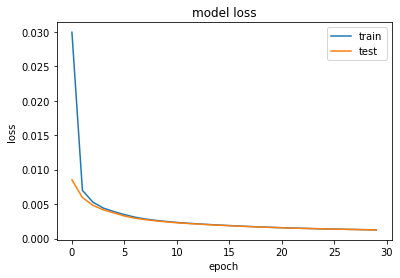

In [48]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

#### Create a new model using only the enconder part after i have trained the model so i can use it as dimensionality reduction tecnique for KNN 

In [49]:
encoder_all = Model(input_layer,encoded_all)

In [50]:
#Output of the encoeded layers
enc_all =  encoder_all.predict(X_train)

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [53]:
knn_model.fit(enc_all,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [54]:
#Making predictions on the test dataset
predictions = knn_model.predict( encoder_all.predict(X_test))

In [55]:
predictions

array([0, 0, 1, ..., 1, 0, 0])

In [56]:
import seaborn as sns
import matplotlib.ticker as ticker 

In [57]:
conf_matrix = confusion_matrix(Y_test,predictions)

2020-11-17 15:09:16,141 [INFO ]  Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-11-17 15:09:16,142 [INFO ]  NumExpr defaulting to 8 threads.


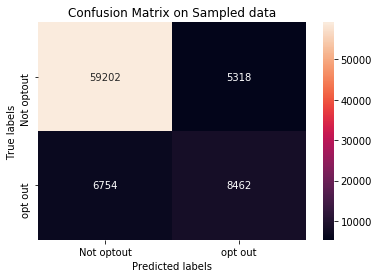

In [58]:
ax = plt.subplot()
sns.heatmap(conf_matrix,annot=True, ax=ax, fmt='g')
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix on Sampled data")
ax.xaxis.set_ticklabels(["Not optout","opt out"])
ax.yaxis.set_ticklabels(["Not optout","opt out"])
ax.set(yticks=[0,2],xticks=[0.5,1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))

In [59]:
autoencoder.save('./model_artifacts/autoencoder_model_time')

2020-11-17 15:09:16,819 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-17 15:09:16,829 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-17 15:09:17,468 [INFO ]  Assets written to: ./model_artifacts/autoencoder_model_time/assets


# Out of Sample performance

In [60]:
loaded_model = keras.models.load_model("./model_artifacts/autoencoder_model_time")

In [66]:

sql_code = '''
select * from campaign_data.opt_out_202009_all_combined_comm
'''
iterator= athena.execute_query(sql_code, **{'chunksize':500000})

2020-11-17 15:22:50,480 [INFO ]  starting Athena query ...
2020-11-17 15:28:43,178 [INFO ]  loading 62d3c381-4e1f-4718-ae0d-083f40d7e3fe.csv
2020-11-17 15:28:43,331 [INFO ]  Athena query complete: returning iterator object


In [ ]:
scores_list = []
i=0
for chunk in iterator:
    print(i)
    print( chunk.groupby('optout_flag')['optout_flag'].count())
    chunk = numeric_fill_na(chunk)
    chunk = categorical_fill_na(chunk)
    chunk = replacing_empty_strings(chunk)
    #del chunk['account_num']
    del chunk['optout_date']
    #del chunk['activesub']
    del chunk['ee_customer_id']
    del chunk['optout_cnt']
   
    X_out = chunk.loc[:, chunk.columns != 'optout_flag']
    Y_out = chunk.optout_flag.values
    X_out = one_hot_encoding_test(X_out)
    X_out = scaler.transform(X_out)
    predictions = knn_model.predict( encoder_all.predict(X_out))
    df_final = pd.DataFrame(columns = ['prediction', 'actual'])
    df_final['prediction'] = predictions
    df_final['actual'] = Y_out
    scores_list.append(df_final)
    print(df_final.actual.unique())
    i=i+1
    #del X_out
    del predictions
    del df_final
    del chunk

0
optout_flag
1    952
Name: optout_flag, dtype: int64
[0 1]
1
optout_flag
1    948
Name: optout_flag, dtype: int64
[0 1]
2
optout_flag
1    927
Name: optout_flag, dtype: int64
[0 1]
3
optout_flag
1    844
Name: optout_flag, dtype: int64


In [ ]:
all_scores = pd.concat(scores_list, ignore_index=True)

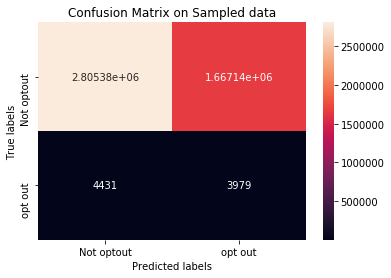

In [70]:
conf_matrix = confusion_matrix(all_scores.actual,all_scores.prediction)
ax = plt.subplot()
sns.heatmap(conf_matrix,annot=True, ax=ax, fmt='g')
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix on Sampled data")
ax.xaxis.set_ticklabels(["Not optout","opt out"])
ax.yaxis.set_ticklabels(["Not optout","opt out"])
ax.set(yticks=[0,2],xticks=[0.5,1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))